# Generate heatmap and dendrograms of sequence/structure similarity for Uniprot SQR protein Q7ZAG8

For sponsor meeting on 250212

In [94]:
# import packages
import io
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Bio.Align.Applications import ClustalwCommandline
from Bio import SeqIO

## filter fasta so it only contains entries with pdb files

In [5]:
fasta_path = "../data/uniprotkb_uniref_cluster_50_UniRef50_Q7_2025_02_11.fasta"
fasta_sequences = SeqIO.parse(open(fasta_path), "fasta")

filtered_sequences = {}
tot_seq = 0

for fasta in fasta_sequences:
    f_id, f_seq = fasta.id, str(fasta.seq)
    acc_id = f_id.split("|")[1]

    if os.path.exists(f"../structures/AF-{acc_id}-F1-model_v4.pdb"):
        filtered_sequences[f_id] = f_seq
    tot_seq += 1

print(tot_seq)
print(len(filtered_sequences))


91
73


In [11]:
with open("../data/uniprotkb_uniref_cluster_50_UniRef50_Q7_2025_02_11_withstruct.fasta", "w") as outfile:
    for f_id, f_seq in filtered_sequences.items():
        outfile.write(f">{f_id}\n")
        outfile.write(f"{f_seq}\n")

then run ./download_af_pdb.sh on this new file

this will produce 73 files, each containing foldseek scores for a query protein against all target proteins in the directory

## parse clustal outputs

this is supposed to be done with the bioai clustalwcommandline package improt but I couldnt figure it out in time

so instead I used the EBI clustal website and imported the fasta there:
https://www.ebi.ac.uk/jdispatcher/msa/clustalo

then downloaded one of the files (pim) and parsed, contains pairwise scores of sequence similarity between proteins


In [188]:
with open("../clustal_output/pim", "r") as infile:
    lines = infile.readlines()

data_lines = [line.strip() for line in lines if not line.startswith("#") and line.strip()]

column_names = ["Index", "id"]  # Initial columns before the matrix values
num_columns = len(data_lines[0].split()) - 2  # Excluding index and identifier
column_names.extend([f"Col_{i+1}" for i in range(num_columns)])

# Process data into a list of lists
data = []
for line in data_lines:
    parts = re.split(r'\s+', line, maxsplit=2)  # Split first three elements
    index, identifier, values_str = parts
    values = list(map(float, values_str.split()))  # Convert values to float
    data.append([int(index[:-1]), identifier] + values)  # Remove ':' from index

# Create DataFrame
cl_df = pd.DataFrame(data, columns=column_names)

In [ ]:
cl_reorder = cl_df.iloc[row_order, col_order]
cl_reorder = cl_reorder.drop(columns="C3N8C6")
cl_reorder = cl_reorder.drop(index="C3N8C6")

cl_reorder.head()

id,A0A0G3VSM4,A0A2U9IDS8,A0A1W6JY79,A0A2U9IL46,A0A6A9QM00,A0A650CZ34,A0A2T9X3W1,F4B9A7,H2C917,A0A6N0NWW7,...,Q9HJ43,A0A218NLX2,A0A1V0N6C9,A0A7K4FNR5,S0ASD2,T0M9B9,T0NA02,Q6L1M8,A0A0D8DJU1,A0A0N8PQL1
id,,,,,,,,,,,,,,,,,,,,,
A0A0G3VSM4,100.00,97.07,81.17,82.15,83.37,82.89,83.62,83.86,67.73,68.70,...,52.96,50.12,55.01,55.01,55.01,54.68,55.01,58.92,55.99,56.23
A0A2U9IDS8,97.07,100.00,82.89,83.62,84.60,83.62,84.35,84.11,67.48,68.46,...,52.46,50.86,55.01,55.01,55.01,55.67,55.99,58.68,56.23,56.48
A0A1W6JY79,81.17,82.89,100.00,96.33,85.33,85.09,85.82,85.33,71.64,72.62,...,51.97,51.10,56.97,56.97,56.97,57.64,57.95,57.70,57.70,57.95
A0A2U9IL46,82.15,83.62,96.33,100.00,86.55,85.82,86.31,86.06,73.11,73.84,...,52.96,51.83,56.23,56.23,56.23,56.40,56.72,58.19,57.21,57.46
A0A6A9QM00,83.37,84.60,85.33,86.55,100.00,95.11,95.11,95.11,72.86,72.62,...,52.71,52.32,56.48,56.48,56.48,57.14,57.46,58.92,55.99,56.23


In [189]:
cl_df["id"] = cl_df["id"].apply(lambda x: x.split("|")[1])
cl_df = cl_df.drop(columns="Index")

new_column_names = ["id"] + [col for col in cl_df["id"]]
cl_df.columns = new_column_names
cl_df.columns.name = "id"
cl_df = cl_df.set_index("id")
cl_df.head()

id,Q979D2,A0A2V4GSJ0,A0A5J5FE90,Q9HJ43,A0A218NLX2,Q6L1M8,A0A0D8DJU1,A0A0N8PQL1,A0A1V0N6C9,A0A7K4FNR5,...,A0A031LPE7,A0A7K4FTN2,W7KZJ4,A0A2U9IF83,A0A6A9QER1,Q7ZAG8,A0A650CWW9,F4B6B3,A0A1W6JZH6,A0A2U9IM87
id,,,,,,,,,,,,,,,,,,,,,
Q979D2,100.00,78.54,79.27,78.62,44.36,48.04,46.08,46.32,46.08,46.08,...,53.07,52.83,52.58,52.83,51.60,51.35,51.35,51.35,52.83,53.07
A0A2V4GSJ0,78.54,100.00,90.98,91.15,43.87,50.00,46.08,46.32,48.53,48.53,...,54.79,54.55,55.53,53.32,54.30,54.05,54.05,54.05,54.05,54.30
A0A5J5FE90,79.27,90.98,100.00,95.33,44.61,50.49,47.79,48.04,49.02,49.02,...,54.05,54.05,55.28,52.33,53.32,53.07,53.07,53.07,53.07,53.32
Q9HJ43,78.62,91.15,95.33,100.00,44.23,49.63,46.93,47.17,48.40,48.40,...,53.20,53.45,55.17,52.46,53.69,53.45,53.45,53.45,52.96,53.20
A0A218NLX2,44.36,43.87,44.61,44.23,100.00,72.02,73.24,73.48,72.75,72.75,...,54.52,54.52,53.30,54.52,54.52,55.01,55.01,54.52,53.55,53.79


In [190]:
# cl_df = cl_df.fillna(0)

cl_df = cl_df.drop(columns="C3N8C6")
cl_df = cl_df.drop(index="C3N8C6")

<function matplotlib.pyplot.show(close=None, block=None)>

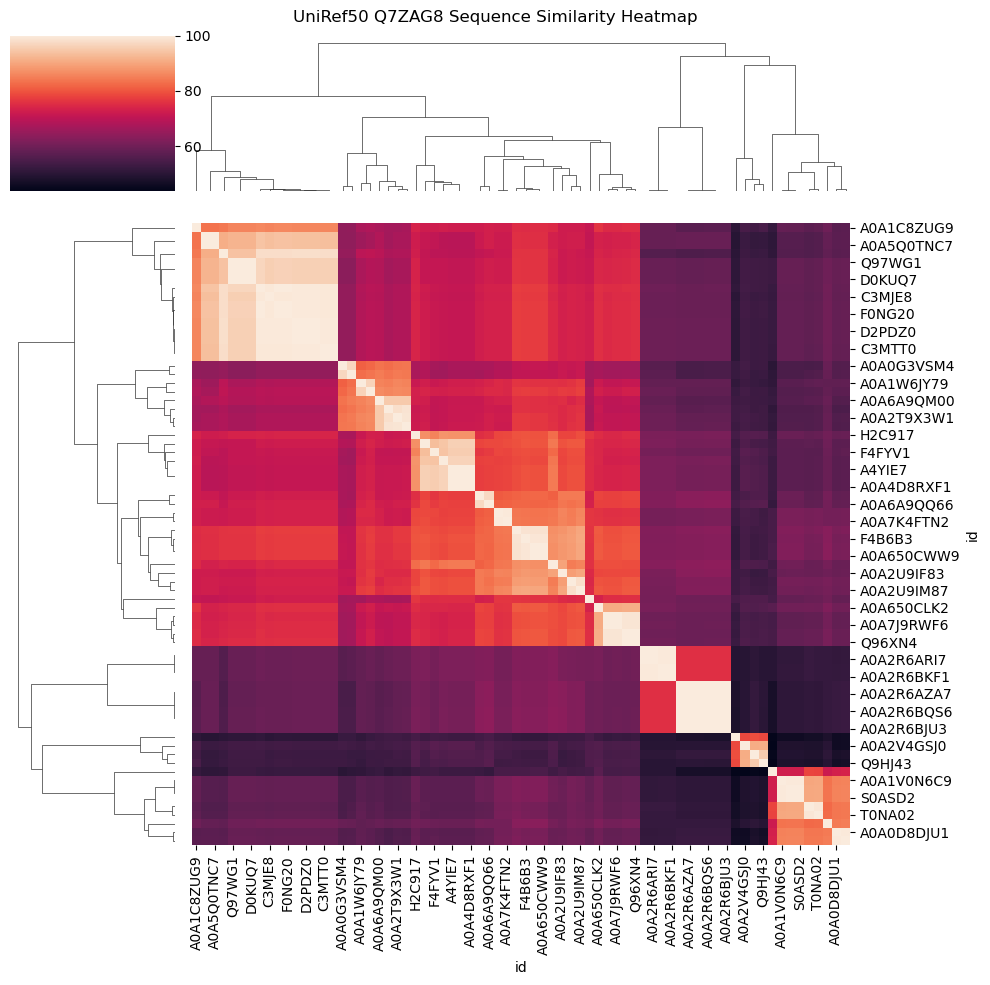

In [191]:
cl_cluster = sns.clustermap(cl_df)
plt.suptitle("UniRef50 Q7ZAG8 Sequence Similarity Heatmap")
plt.tight_layout()
plt.show

## parse all foldseek easy search data

In [63]:
def load_fs_results(easy_search_path):

    fs_df = pd.read_csv(
        easy_search_path, 
        sep="\t", 
        names=["query", "target", "fident", "alnlen", "mismatch", "gapopen", "qstart", "qend", "tstart", "tend", "evalue", "bits"])
    
    if len(fs_df) == 0:
        return None
    fs_df["target_id"] = fs_df["target"].apply(lambda x: x.split("-")[1])

    query_name = fs_df.loc[0, "query"].split("-")[1]
    # print(query_name)

    fs_row = fs_df[["target_id", "evalue"]].set_index("target_id").T.reset_index(drop=True)
    fs_row["query_id"] = query_name
    fs_row = fs_row.set_index("query_id")

    return fs_row

In [64]:
fs_matrix = pd.DataFrame()

for filename in os.listdir("../foldseek_output/"):

    # print(filename)
    filename_path = f"../foldseek_output/{filename}"

    fs_row = load_fs_results(filename_path)

    if fs_row is None:
        print(f"unable to parse {filename}, continuing...")
    else:
        fs_matrix = pd.concat([fs_matrix, fs_row])

print(fs_matrix.shape)
fs_matrix.head()

unable to parse fs_easy_search_C3N8C6.tsv, continuing...
(73, 73)


target_id,A0A031LPE7,A0A7K4FTN2,A0A2U9IM87,A0A6A9QER1,A0A1W6JZH6,F4B6B3,W7KZJ4,A0A650CWW9,A0A510DYP9,A0A6A9QQ66,...,A0A0N8PQL1,S0ASD2,A0A0Q0VQ24,T0M9B9,A0A5J5FE90,Q9HJ43,A0A2V4GSJ0,A0A218NLX2,Q979D2,C3N8C7
query_id,,,,,,,,,,,,,,,,,,,,,
A0A031LPE7,7.030000e-96,7.769000e-94,4.603000e-88,7.815000e-88,2.003000e-87,2.253000e-87,8.713000e-87,1.169000e-86,3.370000e-86,1.159000e-85,...,2.038000e-69,2.293000e-69,2.431000e-69,9.488000e-70,3.022000e-67,7.303000e-67,1.039000e-66,8.142000e-66,7.175000e-65,2.918000e-63
A0A088E925,6.518000e-84,2.514000e-84,1.332000e-83,3.386000e-84,7.792000e-84,5.452000e-84,5.905000e-86,1.904000e-83,5.559000e-83,1.941000e-82,...,6.236000e-68,1.045000e-68,7.311000e-69,2.012000e-68,1.857000e-66,1.857000e-66,1.379000e-66,1.044000e-65,1.492000e-65,1.175000e-62
A0A0D8DJU1,3.451000e-68,2.178000e-68,1.830000e-67,5.467000e-68,6.891000e-69,4.873000e-68,1.456000e-68,2.056000e-68,2.175000e-67,4.095000e-67,...,7.094000e-91,2.100000e-84,4.477000e-91,2.489000e-82,1.522000e-58,2.032000e-59,2.411000e-58,6.584000e-78,6.404000e-57,7.550000e-51
A0A0E3MEX3,6.070000e-82,7.686000e-82,3.169000e-81,6.830000e-82,1.976000e-81,2.503000e-81,8.148000e-81,7.241000e-81,2.224000e-81,1.306000e-80,...,1.084000e-67,1.220000e-67,5.034000e-68,4.470000e-67,1.637000e-65,3.133000e-65,2.199000e-65,6.743000e-64,1.541000e-63,4.752000e-70
A0A0G3VSM4,6.890000e-79,1.407000e-78,6.768000e-80,1.975000e-79,6.768000e-80,7.183000e-80,1.753000e-79,1.557000e-79,3.869000e-78,1.493000e-78,...,2.925000e-67,7.577000e-67,1.349000e-67,1.020000e-66,2.251000e-65,1.424000e-64,4.154000e-64,2.581000e-64,1.951000e-63,1.681000e-58


In [82]:
fs_matrix_log = -np.log10(fs_matrix)
fs_matrix_log.head()

target_id,A0A031LPE7,A0A7K4FTN2,A0A2U9IM87,A0A6A9QER1,A0A1W6JZH6,F4B6B3,W7KZJ4,A0A650CWW9,A0A510DYP9,A0A6A9QQ66,...,A0A0N8PQL1,S0ASD2,A0A0Q0VQ24,T0M9B9,A0A5J5FE90,Q9HJ43,A0A2V4GSJ0,A0A218NLX2,Q979D2,C3N8C7
query_id,,,,,,,,,,,,,,,,,,,,,
A0A031LPE7,95.153045,93.109635,87.336959,87.107071,86.698319,86.647239,86.059832,85.932185,85.472370,84.935917,...,68.690796,68.639596,68.614215,69.022825,66.519706,66.136499,65.983384,65.089269,64.144178,62.534915
A0A088E925,83.185886,83.599635,82.875496,83.470313,83.108351,83.263444,85.228780,82.720333,82.255003,81.711974,...,67.205094,67.980884,68.136023,67.696372,65.731188,65.731188,65.860436,64.981300,64.826231,61.929962
A0A0D8DJU1,67.462055,67.661942,66.737549,67.262251,68.161718,67.312204,67.836839,67.686977,66.662541,66.387746,...,90.149109,83.677781,90.349013,81.603975,57.817585,58.692076,57.617803,77.181510,56.193549,50.122053
A0A0E3MEX3,81.216811,81.114300,80.499078,81.165579,80.704213,80.601539,80.088949,80.140201,80.652865,79.884057,...,66.964971,66.913640,67.298087,66.349692,64.785951,64.504040,64.657775,63.171147,62.812197,69.323124
A0A0G3VSM4,78.161781,77.851706,79.169540,78.704433,79.169540,79.143694,78.756218,78.807711,77.412401,77.825940,...,66.533874,66.120503,66.869988,65.991400,64.647625,63.846490,63.381534,63.588212,62.709743,57.774432


<function matplotlib.pyplot.show(close=None, block=None)>

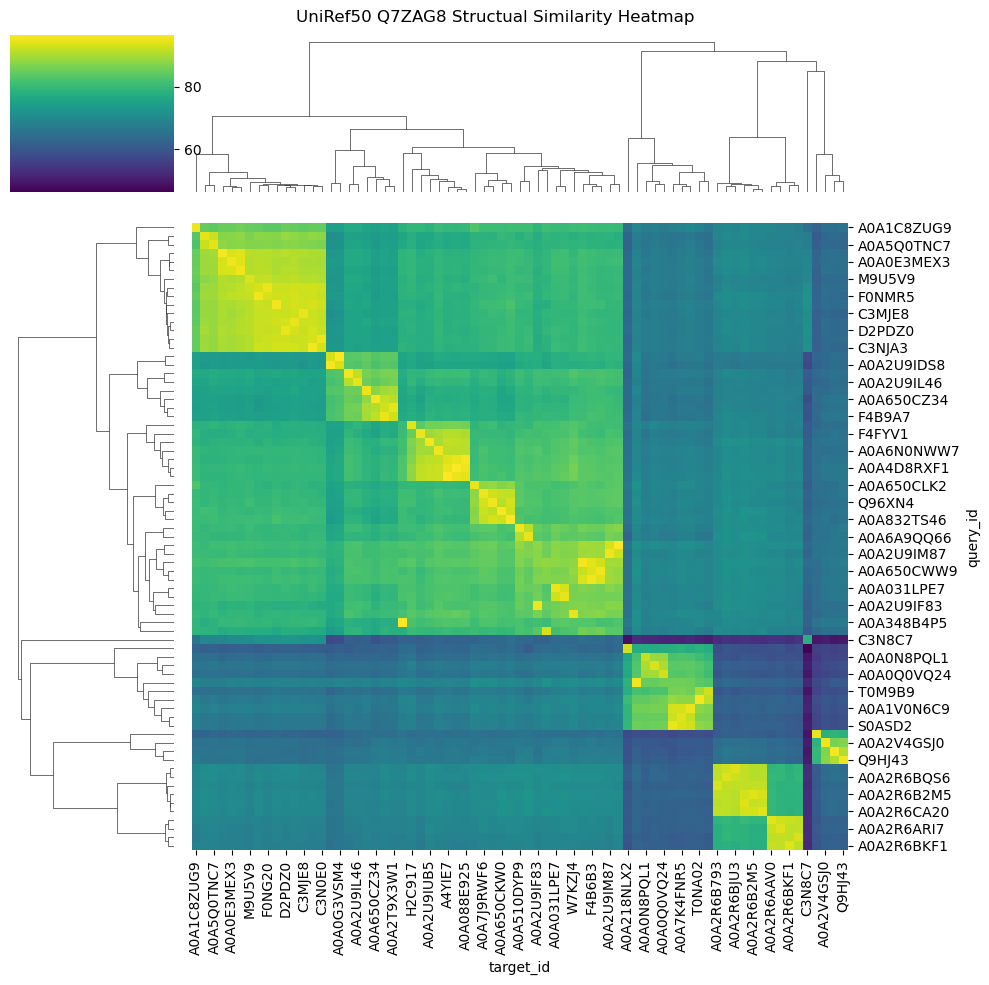

In [196]:
fs_cluster = sns.clustermap(fs_matrix_log, cmap="viridis")
plt.suptitle("UniRef50 Q7ZAG8 Structual Similarity Heatmap")
plt.tight_layout()
plt.show

## color sequence clustermap by structure

In [177]:
row_order = cl_cluster.dendrogram_row.reordered_ind
col_order = cl_cluster.dendrogram_col.reordered_ind

row_ids = cl_df.index.values[row_order]
col_ids = cl_df.index.values[col_order]

In [178]:
cl_reorder = cl_df.iloc[row_order, col_order]
cl_reorder = cl_reorder.drop(columns="C3N8C6")
cl_reorder = cl_reorder.drop(index="C3N8C6")

print(cl_reorder.shape)
cl_reorder.head()

(72, 72)


id,A0A0G3VSM4,A0A2U9IDS8,A0A1W6JY79,A0A2U9IL46,A0A6A9QM00,A0A650CZ34,A0A2T9X3W1,F4B9A7,H2C917,A0A6N0NWW7,...,Q9HJ43,A0A218NLX2,A0A1V0N6C9,A0A7K4FNR5,S0ASD2,T0M9B9,T0NA02,Q6L1M8,A0A0D8DJU1,A0A0N8PQL1
id,,,,,,,,,,,,,,,,,,,,,
A0A0G3VSM4,100.00,97.07,81.17,82.15,83.37,82.89,83.62,83.86,67.73,68.70,...,52.96,50.12,55.01,55.01,55.01,54.68,55.01,58.92,55.99,56.23
A0A2U9IDS8,97.07,100.00,82.89,83.62,84.60,83.62,84.35,84.11,67.48,68.46,...,52.46,50.86,55.01,55.01,55.01,55.67,55.99,58.68,56.23,56.48
A0A1W6JY79,81.17,82.89,100.00,96.33,85.33,85.09,85.82,85.33,71.64,72.62,...,51.97,51.10,56.97,56.97,56.97,57.64,57.95,57.70,57.70,57.95
A0A2U9IL46,82.15,83.62,96.33,100.00,86.55,85.82,86.31,86.06,73.11,73.84,...,52.96,51.83,56.23,56.23,56.23,56.40,56.72,58.19,57.21,57.46
A0A6A9QM00,83.37,84.60,85.33,86.55,100.00,95.11,95.11,95.11,72.86,72.62,...,52.71,52.32,56.48,56.48,56.48,57.14,57.46,58.92,55.99,56.23


In [179]:
fs_matrix_log_reorder = fs_matrix_log.loc[[x for x in row_ids if x != "C3N8C6"], [x for x in row_ids if x != "C3N8C6"]]

print(fs_matrix_log_reorder.shape)
fs_matrix_log_reorder.head()

(72, 72)


target_id,A0A0G3VSM4,A0A2U9IDS8,A0A1W6JY79,A0A2U9IL46,A0A6A9QM00,A0A650CZ34,A0A2T9X3W1,F4B9A7,H2C917,A0A6N0NWW7,...,Q9HJ43,A0A218NLX2,A0A1V0N6C9,A0A7K4FNR5,S0ASD2,T0M9B9,T0NA02,Q6L1M8,A0A0D8DJU1,A0A0N8PQL1
query_id,,,,,,,,,,,,,,,,,,,,,
A0A0G3VSM4,96.430392,93.303818,83.458920,83.794796,84.518271,82.941954,83.846490,83.872247,76.663140,76.947306,...,63.846490,63.588212,67.179930,66.999132,66.120503,65.991400,67.412514,70.229001,67.154096,66.533874
A0A2U9IDS8,93.241770,96.081498,83.070428,82.709075,84.180456,82.166853,82.941195,83.225337,76.513286,75.841939,...,63.682773,62.856673,66.238598,65.799697,65.180127,64.818728,66.445148,69.336488,66.341893,65.851397
A0A1W6JY79,82.846490,82.486782,95.413976,91.970211,85.982132,84.979639,86.418961,86.213320,79.094366,80.841939,...,64.753748,62.517841,67.632085,67.606425,66.989700,66.501276,66.963770,69.199833,66.758205,65.755970
A0A2U9IL46,82.553929,81.658961,91.427361,94.726073,85.341321,83.909389,85.903785,85.290137,79.485319,79.869023,...,64.167747,63.144905,66.494850,66.545918,66.264641,65.165071,66.469288,68.182567,66.392545,65.395234
A0A6A9QM00,83.171727,82.916856,85.235674,85.210208,94.867420,87.656394,89.949620,89.541967,77.973875,78.203010,...,64.596365,63.322302,67.118958,67.017006,66.201626,66.125170,67.144420,69.284833,66.379968,65.462685


In [180]:
from matplotlib.colors import Normalize
from matplotlib import cm


In [ ]:
norm = Normalize(vmin=fs_matrix_log_reorder.min().min(), vmax=fs_matrix_log_reorder.max().max())
cmap = cm.viridis  # You can choose any colormap, e.g., 'viridis', 'plasma', etc.

# Apply the colormap to the numerical values in color_df
color_values = fs_matrix_log_reorder.values
colors_mapped = cmap(norm(color_values))

colors_hex = ['#%02x%02x%02x' % (int(c[0] * 255), int(c[1] * 255), int(c[2] * 255)) for c in colors_mapped.mean(axis=0)]
color_series = pd.Series(colors_hex, index=fs_matrix_log_reorder.index)


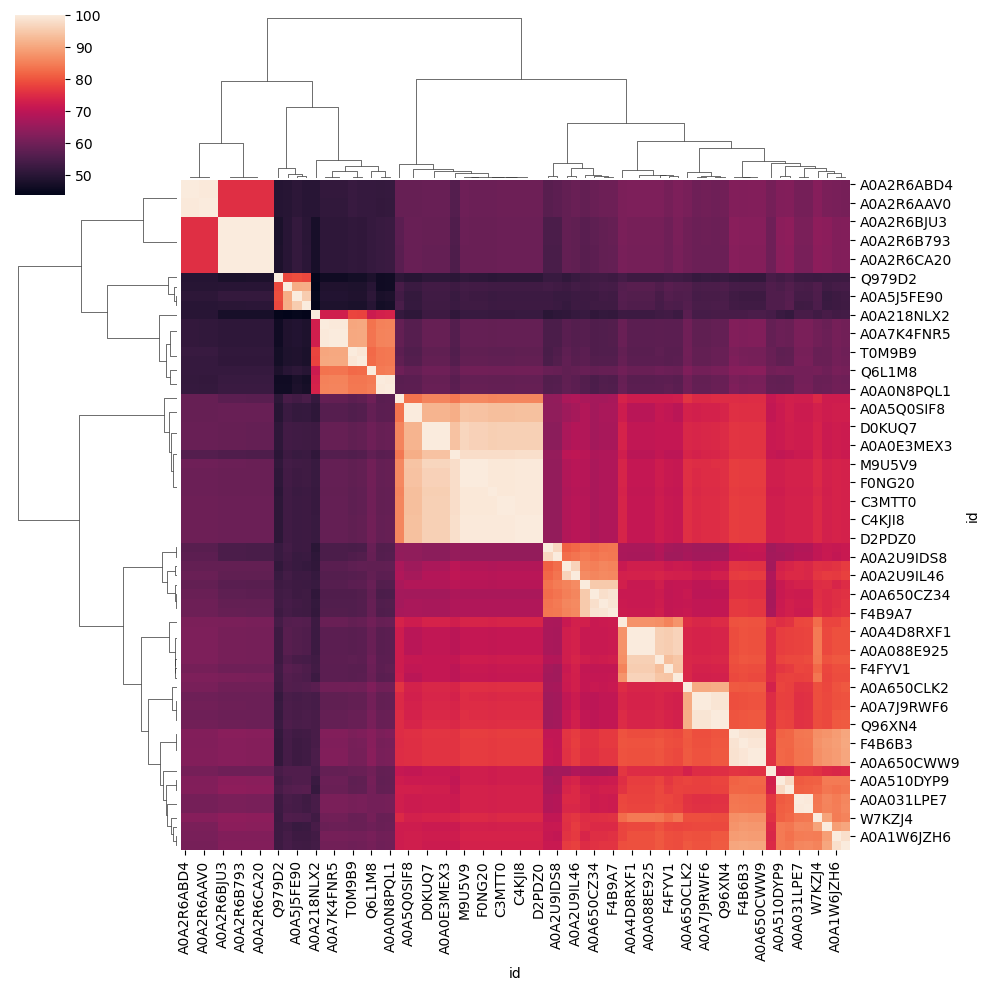

In [ ]:
sns.clustermap(cl_reorder, metric="euclidean", method="ward")


In [205]:
display(fs_matrix_log_reorder.head())
display(cl_reorder.head())

target_id,A0A0G3VSM4,A0A2U9IDS8,A0A1W6JY79,A0A2U9IL46,A0A6A9QM00,A0A650CZ34,A0A2T9X3W1,F4B9A7,H2C917,A0A6N0NWW7,...,Q9HJ43,A0A218NLX2,A0A1V0N6C9,A0A7K4FNR5,S0ASD2,T0M9B9,T0NA02,Q6L1M8,A0A0D8DJU1,A0A0N8PQL1
query_id,,,,,,,,,,,,,,,,,,,,,
A0A0G3VSM4,96.430392,93.303818,83.458920,83.794796,84.518271,82.941954,83.846490,83.872247,76.663140,76.947306,...,63.846490,63.588212,67.179930,66.999132,66.120503,65.991400,67.412514,70.229001,67.154096,66.533874
A0A2U9IDS8,93.241770,96.081498,83.070428,82.709075,84.180456,82.166853,82.941195,83.225337,76.513286,75.841939,...,63.682773,62.856673,66.238598,65.799697,65.180127,64.818728,66.445148,69.336488,66.341893,65.851397
A0A1W6JY79,82.846490,82.486782,95.413976,91.970211,85.982132,84.979639,86.418961,86.213320,79.094366,80.841939,...,64.753748,62.517841,67.632085,67.606425,66.989700,66.501276,66.963770,69.199833,66.758205,65.755970
A0A2U9IL46,82.553929,81.658961,91.427361,94.726073,85.341321,83.909389,85.903785,85.290137,79.485319,79.869023,...,64.167747,63.144905,66.494850,66.545918,66.264641,65.165071,66.469288,68.182567,66.392545,65.395234
A0A6A9QM00,83.171727,82.916856,85.235674,85.210208,94.867420,87.656394,89.949620,89.541967,77.973875,78.203010,...,64.596365,63.322302,67.118958,67.017006,66.201626,66.125170,67.144420,69.284833,66.379968,65.462685


id,A0A0G3VSM4,A0A2U9IDS8,A0A1W6JY79,A0A2U9IL46,A0A6A9QM00,A0A650CZ34,A0A2T9X3W1,F4B9A7,H2C917,A0A6N0NWW7,...,Q9HJ43,A0A218NLX2,A0A1V0N6C9,A0A7K4FNR5,S0ASD2,T0M9B9,T0NA02,Q6L1M8,A0A0D8DJU1,A0A0N8PQL1
id,,,,,,,,,,,,,,,,,,,,,
A0A0G3VSM4,100.00,97.07,81.17,82.15,83.37,82.89,83.62,83.86,67.73,68.70,...,52.96,50.12,55.01,55.01,55.01,54.68,55.01,58.92,55.99,56.23
A0A2U9IDS8,97.07,100.00,82.89,83.62,84.60,83.62,84.35,84.11,67.48,68.46,...,52.46,50.86,55.01,55.01,55.01,55.67,55.99,58.68,56.23,56.48
A0A1W6JY79,81.17,82.89,100.00,96.33,85.33,85.09,85.82,85.33,71.64,72.62,...,51.97,51.10,56.97,56.97,56.97,57.64,57.95,57.70,57.70,57.95
A0A2U9IL46,82.15,83.62,96.33,100.00,86.55,85.82,86.31,86.06,73.11,73.84,...,52.96,51.83,56.23,56.23,56.23,56.40,56.72,58.19,57.21,57.46
A0A6A9QM00,83.37,84.60,85.33,86.55,100.00,95.11,95.11,95.11,72.86,72.62,...,52.71,52.32,56.48,56.48,56.48,57.14,57.46,58.92,55.99,56.23


In [211]:
def get_val(df, acc_id1, acc_id2):
    return df.loc[acc_id1, acc_id2]

id_pairs = []
cl_vals = []
fs_vals = []

for acc_id1 in fs_matrix_log_reorder.index:
    for acc_id2 in fs_matrix_log_reorder.index:
        id_pair = acc_id1 + "_" + acc_id2
        cl_val = get_val(cl_reorder, acc_id1, acc_id2)
        fs_val = get_val(fs_matrix_log_reorder, acc_id1, acc_id2)

        id_pairs.append(id_pair)
        cl_vals.append(cl_val)
        fs_vals.append(fs_val)

corr_df = pd.DataFrame({
    "id_pairs": id_pairs,
    "cl_val": cl_vals,
    "fs_val": fs_vals})

corr_df.head()

,id_pairs,cl_val,fs_val
0,A0A0G3VSM4_A0A0G3VSM4,100.00,96.430392
1,A0A0G3VSM4_A0A2U9IDS8,97.07,93.303818
2,A0A0G3VSM4_A0A1W6JY79,81.17,83.458920
3,A0A0G3VSM4_A0A2U9IL46,82.15,83.794796
4,A0A0G3VSM4_A0A6A9QM00,83.37,84.518271


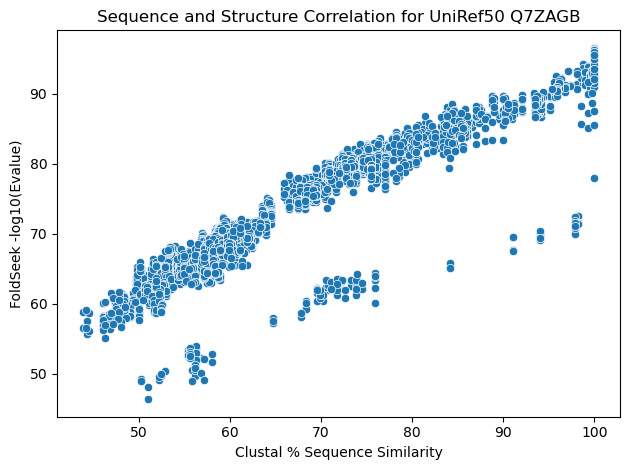

In [221]:
sns.scatterplot(corr_df, x="cl_val", y="fs_val")
plt.xlabel("Clustal % Sequence Similarity")
plt.ylabel("FoldSeek -log10(Evalue)")
plt.title("Sequence and Structure Correlation for UniRef50 Q7ZAGB")
plt.tight_layout()
plt.show()

In [214]:
corr_df["id_1"] = corr_df["id_pairs"].apply(lambda x: x.split("_")[0])
corr_df["id_2"] = corr_df["id_pairs"].apply(lambda x: x.split("_")[1])

In [219]:
corr_df[(corr_df["cl_val"] > 90) & (corr_df["fs_val"] < 70)]

,id_pairs,cl_val,fs_val,id_1,id_2
2411,C3N8C7_A0A5Q0SIF8,91.02,69.449894,C3N8C7,A0A5Q0SIF8
2412,C3N8C7_A0A5Q0TNC7,91.02,69.527682,C3N8C7,A0A5Q0TNC7
2413,C3N8C7_Q97WG1,94.01,69.709075,C3N8C7,Q97WG1
2553,A0A5Q0SIF8_C3N8C7,91.02,67.625435,A0A5Q0SIF8,C3N8C7
2625,A0A5Q0TNC7_C3N8C7,91.02,67.529737,A0A5Q0TNC7,C3N8C7
2697,Q97WG1_C3N8C7,94.01,69.112833,Q97WG1,C3N8C7
2769,A0A0E3MEX3_C3N8C7,94.01,69.323124,A0A0E3MEX3,C3N8C7
2841,D0KUQ7_C3N8C7,94.01,69.348625,D0KUQ7,C3N8C7
2913,M9U5V9_C3N8C7,97.87,69.892790,M9U5V9,C3N8C7


In [220]:
corr_df[(corr_df["cl_val"] < 90) & (corr_df["fs_val"] < 80)]["id_1"].value_counts()

id_1
A0A218NLX2    71
Q979D2        71
A0A2V4GSJ0    69
A0A5J5FE90    69
Q9HJ43        69
              ..
A0A650CWW9    35
A0A2U9IM87    31
F4B6B3        27
A0A1W6JZH6    27
A0A6A9QER1    26
Name: count, Length: 72, dtype: int64

In [206]:
correlations = fs_matrix_log_reorder.corrwith(cl_reorder)
print(correlations)

target_id
A0A0G3VSM4    0.944970
A0A2U9IDS8    0.938893
A0A1W6JY79    0.940754
A0A2U9IL46    0.948974
A0A6A9QM00    0.948234
                ...   
T0M9B9        0.960705
T0NA02        0.960972
Q6L1M8        0.951306
A0A0D8DJU1    0.956141
A0A0N8PQL1    0.962982
Length: 72, dtype: float64


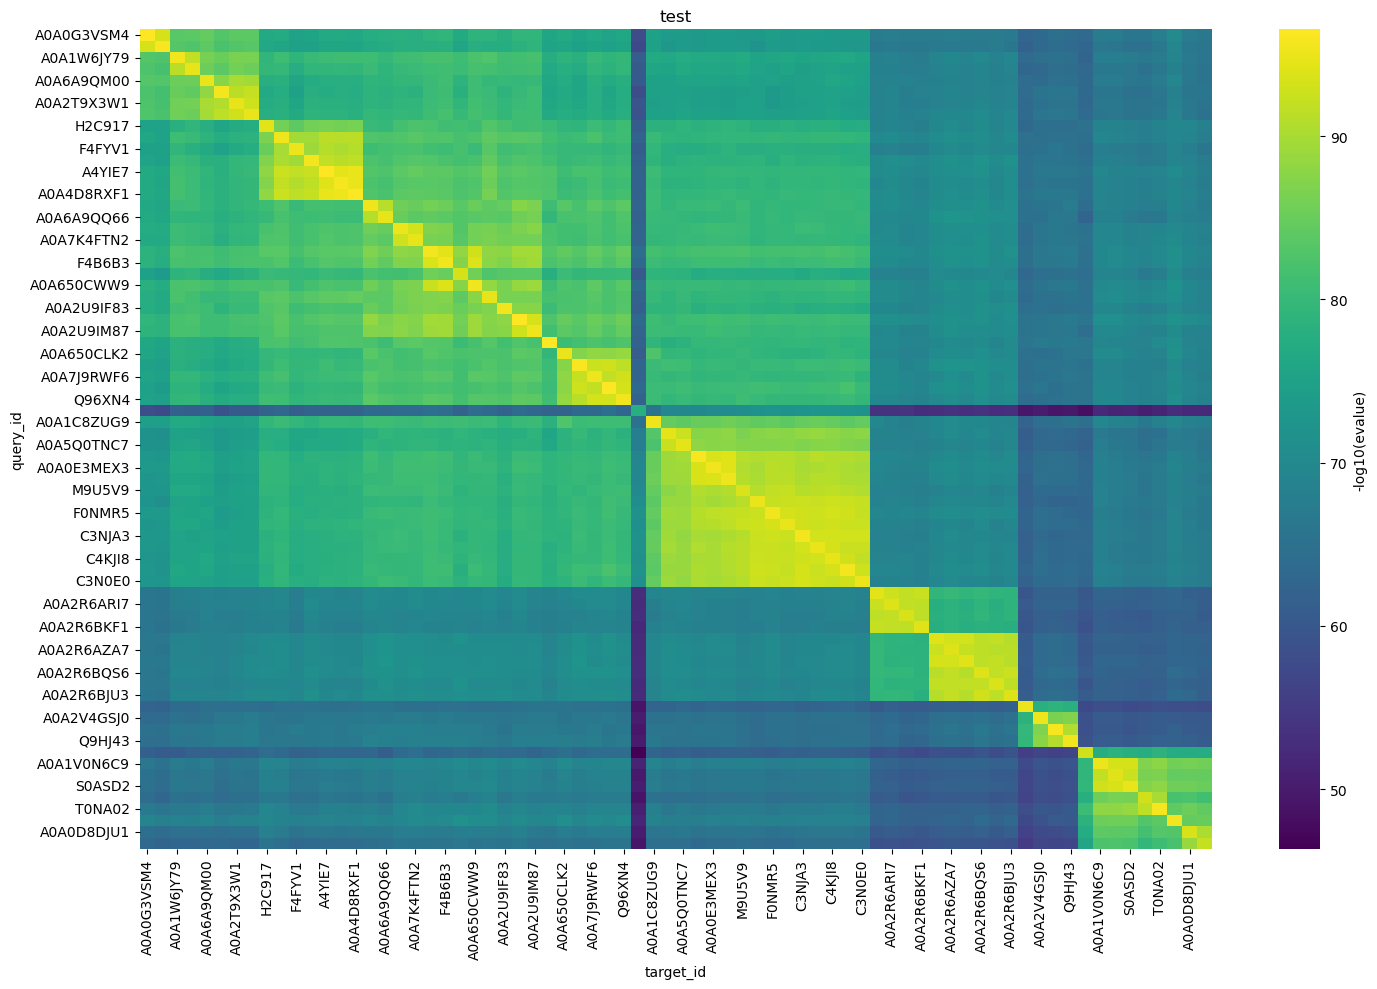

In [204]:
fig = plt.figure(figsize=(15, 10))
sns.heatmap(fs_matrix_log_reorder, cmap="viridis", cbar_kws={"label": "-log10(evalue)"})
plt.title("test")
plt.tight_layout()
plt.show()


72


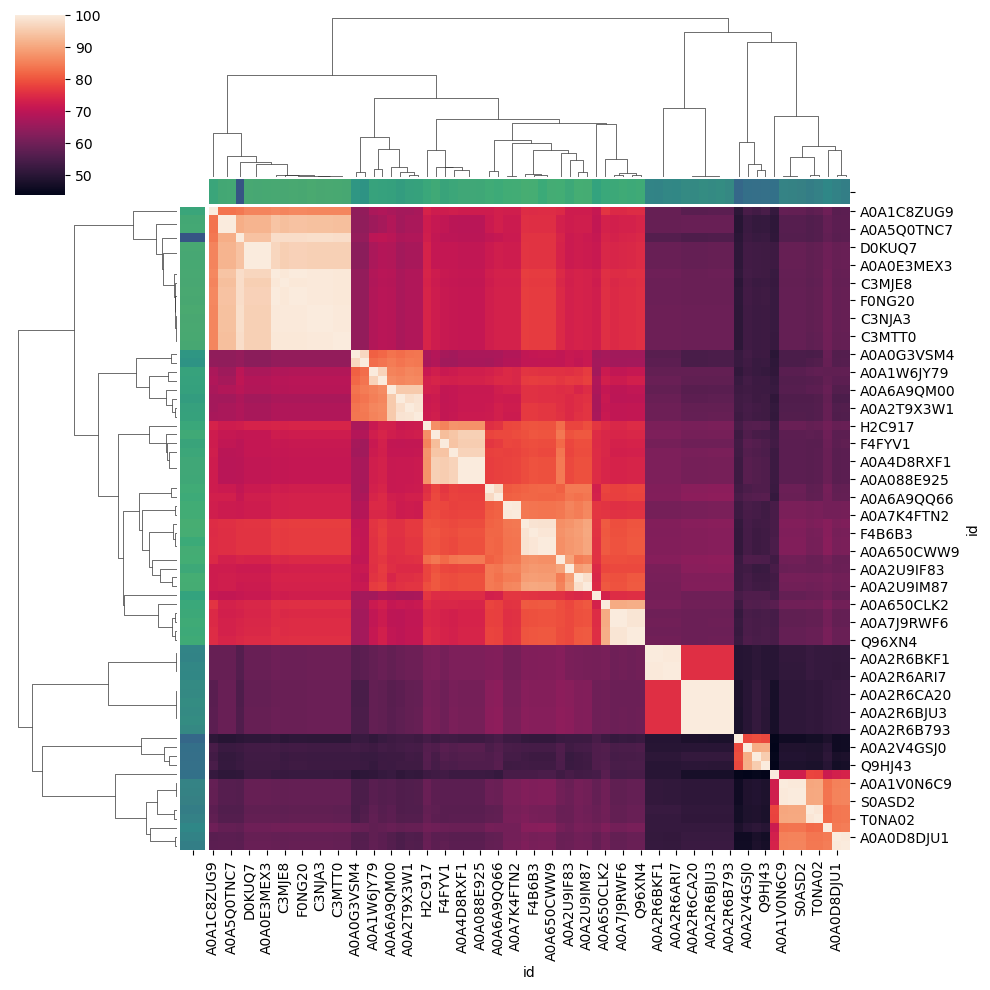

In [ ]:
print(len(color_series))

sns.clustermap(cl_reorder, col_colors=color_series, row_colors=color_series)
plt.title()